In [1]:
%matplotlib inline

In [2]:
#__ = plt.style.use("./diffstar.mplstyle")
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"

colors = [mpurple,mblue,mgreen,morange, mred]

In [3]:
import subprocess


def try_enable_latex():
    """Try enabling LaTeX text rendering in matplotlib,
    fallback if not available."""
    try:
        # Quick check: can we run latex?
        subprocess.check_call(
            ["latex", "--version"],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
        )
        plt.rc("text", usetex=True)
        plt.rc("font", family="serif", size=22)
        plt.rc('figure', figsize=(6,4)) 
        print("LaTeX rendering enabled.")
    except (subprocess.CalledProcessError, FileNotFoundError):
        # LaTeX not installed or failed
        plt.rc("text", usetex=False)
        plt.rc("font", family="serif", size=22)
        plt.rc('figure', figsize=(6,4)) 
        print("LaTeX not available, falling back to default mathtext.")

try_enable_latex()

LaTeX rendering enabled.


In [4]:
from diffmah.diffmah_kernels import mah_halopop
from diffsky.mass_functions.mc_diffmah_tpeak import mc_subhalos
from jax import random as jran

from diffsky.mass_functions.mc_diffmah_tpeak import mc_subhalos
from dsps.constants import T_TABLE_MIN
from jax import jit as jjit
from jax import numpy as jnp
from jax import random as jran
from jax import value_and_grad

from diffstar.defaults import LGT0

from diffstar.diffstarpop import mc_diffstar_sfh_galpop


### Load `DiffstarPop` parameters fitted to different simulations

In [5]:
from diffstar.diffstarpop.kernels.params import (
    DiffstarPop_Params_Diffstarpopfits_mgash, 
)
print(DiffstarPop_Params_Diffstarpopfits_mgash.keys())


DIFFSTARPOP_UM = DiffstarPop_Params_Diffstarpopfits_mgash["smdpl_dr1_nomerging"]
DIFFSTARPOP_TNG = DiffstarPop_Params_Diffstarpopfits_mgash["tng"]
DIFFSTARPOP_GALCUS = DiffstarPop_Params_Diffstarpopfits_mgash["galacticus_in_situ"]

odict_keys(['smdpl_dr1_nomerging', 'smdpl_dr1', 'tng', 'galacticus_in_situ', 'galacticus_in_plus_ex_situ'])


### Generate a simulated halo catalog with `diffmahpop`

In [6]:
ran_key = jran.PRNGKey(0)

# Generate a random subhalo catalog
subcat_key, ran_key = jran.split(ran_key, 2)
lgmp_min = 11.25
z_obs = 0.01
Lbox = 75.0
volume_com = Lbox**3
subcat = mc_subhalos(subcat_key, z_obs, lgmp_min=lgmp_min, volume_com=volume_com)

### Calculate the SFHs using the UniverseMachine params

In [7]:

ntimes = 50
tarr = np.linspace(0.1, 13.7, ntimes)


dmhdt_fit, log_mah_fit = mah_halopop(subcat.mah_params, tarr, LGT0)
logmp0 = log_mah_fit[:,-1]
# Manually set the infall data of each halo to no infall,
# since this part of the Diffstarpop model has not been calibrated

n_halos = subcat.logmhost_ult_inf.shape[0]

lgmu_infall = -1.0 * np.ones(n_halos)
logmhost_infall = 13.0 * np.ones(n_halos)
gyr_since_infall = -99.0 * np.ones(n_halos)

# compute SFHs for the default galaxy population
args = (
    DIFFSTARPOP_UM,
    subcat.mah_params,
    subcat.logmp0,
    subcat.upids,
    lgmu_infall,
    logmhost_infall,
    gyr_since_infall,
    ran_key,
    tarr,
)

(
    diffstar_params_ms,
    diffstar_params_q,
    default_sfh_ms,
    default_sfh_q,
    frac_q,
    mc_is_q,
) = mc_diffstar_sfh_galpop(*args)

# select at random if a galaxy is MS or Q based on frac_q.
default_sfh = np.zeros_like(default_sfh_ms) 
default_sfh[mc_is_q] = default_sfh_q[mc_is_q]
default_sfh[~mc_is_q] = default_sfh_ms[~mc_is_q]

### Make some plots

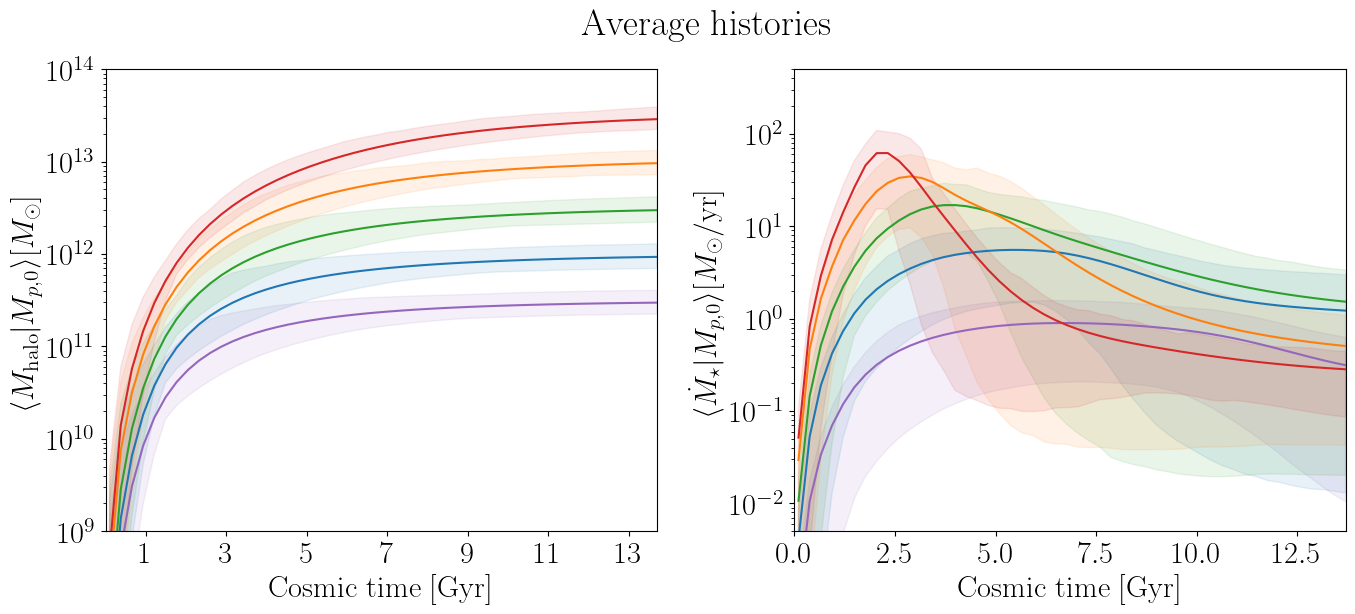

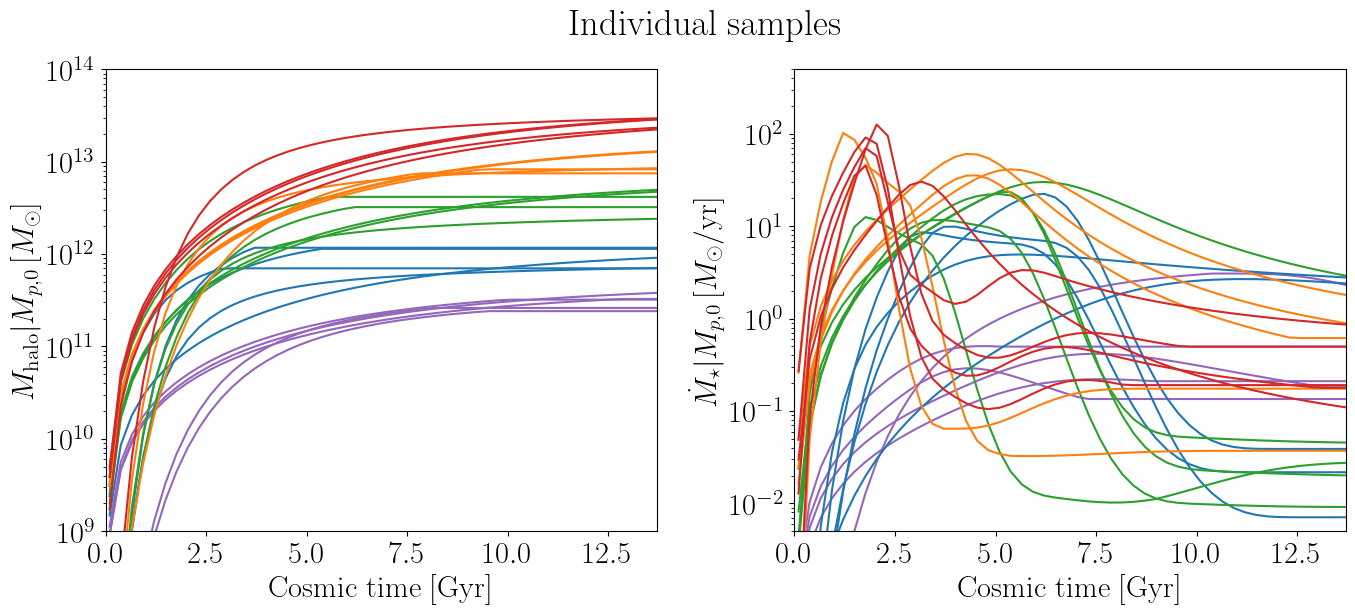

In [8]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
mpeak_vals = np.arange(11.5, 14, 0.5)
for i, mpeak in enumerate(mpeak_vals):
    sel = (subcat.logmp0 > mpeak - 0.2) & (subcat.logmp0 < mpeak + 0.2)
    mean_log_mah_fit = np.mean(log_mah_fit[sel], axis=0)
    mean_default_sfh = np.mean(default_sfh[sel], axis=0)
    range_log_mah_fit = np.percentile(log_mah_fit[sel], [15.865, 84.135], axis=0)
    range_mean_default_sfh = np.percentile(default_sfh[sel], [15.865, 84.135], axis=0)
    
    ax[0].plot(tarr, 10**mean_log_mah_fit, color=colors[i])
    ax[0].fill_between(tarr, 10**range_log_mah_fit[0], 10**range_log_mah_fit[1], color=colors[i], alpha=0.1)
    ax[1].plot(tarr, mean_default_sfh, color=colors[i])
    ax[1].fill_between(tarr, range_mean_default_sfh[0], range_mean_default_sfh[1], color=colors[i], alpha=0.1)


ax[0].set_ylim(1e9, 1e14)
ax[0].set_xticks(np.arange(1.0, 14.0, 2.0))
ax[0].set_xlabel("Cosmic time [Gyr]")
ax[1].set_xlabel("Cosmic time [Gyr]")
ax[0].set_yscale('log')

ax[0].set_xlim(0.0, 13.7)
ax[1].set_xlim(0.0, 13.7)
ax[1].set_yscale('log')
ax[1].set_ylim(5e-3, 5e2)
ax[1].set_ylabel(r"$\langle \dot{M}_\star | M_{p,0} \rangle [M_{\odot}/{\rm yr}]$")
ax[0].set_ylabel(r"$\langle M_{\rm halo} | M_{p,0} \rangle [M_{\odot}]$")

fig.subplots_adjust(wspace=0.25)
fig.suptitle("Average histories")

plt.show()

fig, ax = plt.subplots(1,2, figsize=(16,6))
for i, mpeak in enumerate(mpeak_vals):
    sel = (subcat.logmp0 > mpeak - 0.2) & (subcat.logmp0 < mpeak + 0.2)

    ax[0].plot(tarr, 10**log_mah_fit[sel][np.random.choice(int(sel.sum()), 5)].T, color=colors[i])
    ax[1].plot(tarr, default_sfh[sel][np.random.choice(int(sel.sum()), 5)].T, color=colors[i])



ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(5e-3, 5e2)

ax[0].set_xlim(0.0, 13.7)
ax[1].set_xlim(0.0, 13.7)
ax[0].set_ylim(1e9, 1e14)
ax[0].set_xlabel("Cosmic time [Gyr]")
ax[1].set_xlabel("Cosmic time [Gyr]")
ax[0].set_ylabel(r"$ M_{\rm halo} | M_{p,0} \,[M_{\odot}]$")
ax[1].set_ylabel(r"$\dot{M}_\star | M_{p,0} \,[M_{\odot}/{\rm yr}]$")
fig.subplots_adjust(wspace=0.25)
fig.suptitle("Individual samples")
plt.show()

### Compare SFHs for `DiffstarPop` params fitted to different simulations.

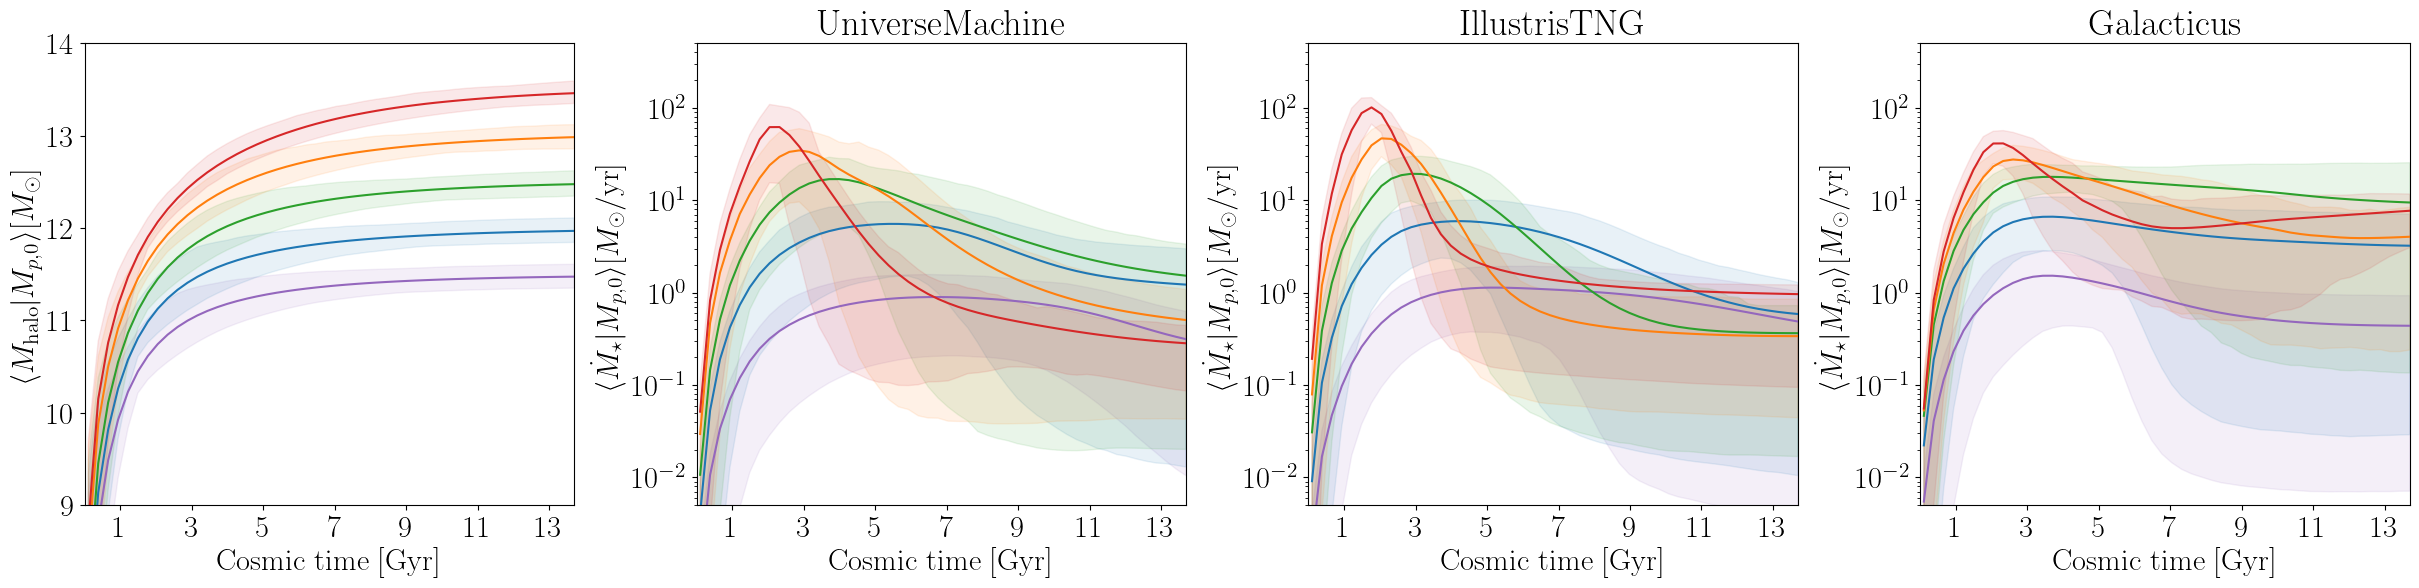

In [9]:
fig, ax = plt.subplots(1,4, figsize=(30,6), sharex=True)
mpeak_vals = np.arange(11.5, 14, 0.5)

for i, mpeak in enumerate(mpeak_vals):
    sel = (subcat.logmp0 > mpeak - 0.2) & (subcat.logmp0 < mpeak + 0.2)
    mean_log_mah_fit = np.mean(log_mah_fit[sel], axis=0)
    range_log_mah_fit = np.percentile(log_mah_fit[sel], [15.865, 84.135], axis=0)
    
    ax[0].plot(tarr, mean_log_mah_fit, color=colors[i])
    ax[0].fill_between(tarr, range_log_mah_fit[0], range_log_mah_fit[1], color=colors[i], alpha=0.1)

for k, params in enumerate([DIFFSTARPOP_UM, DIFFSTARPOP_TNG, DIFFSTARPOP_GALCUS]):
    # compute SFHs for the default galaxy population
    args = (
        params,
        subcat.mah_params,
        subcat.logmp0,
        subcat.upids,
        lgmu_infall,
        logmhost_infall,
        gyr_since_infall,
        ran_key,
        tarr,
    )

    (
        diffstar_params_ms,
        diffstar_params_q,
        default_sfh_ms,
        default_sfh_q,
        frac_q,
        mc_is_q,
    ) = mc_diffstar_sfh_galpop(*args)

    default_sfh = np.zeros_like(default_sfh_ms) 
    default_sfh[mc_is_q] = default_sfh_q[mc_is_q]
    default_sfh[~mc_is_q] = default_sfh_ms[~mc_is_q]

    for i, mpeak in enumerate(mpeak_vals):
        sel = (subcat.logmp0 > mpeak - 0.2) & (subcat.logmp0 < mpeak + 0.2)
        mean_default_sfh = np.mean(default_sfh[sel], axis=0)
        range_mean_default_sfh = np.percentile(default_sfh[sel], [15.865, 84.135], axis=0)
        
        ax[k+1].plot(tarr, mean_default_sfh, color=colors[i])
        ax[k+1].fill_between(tarr, range_mean_default_sfh[0], range_mean_default_sfh[1], color=colors[i], alpha=0.1)


ax[0].set_ylim(9, 14)
ax[0].set_xticks(np.arange(1.0, 14.0, 2.0))
ax[0].set_xlabel("Cosmic time [Gyr]")
ax[1].set_xlabel("Cosmic time [Gyr]")
ax[2].set_xlabel("Cosmic time [Gyr]")
ax[3].set_xlabel("Cosmic time [Gyr]")
ax[0].set_xlim(0.0, 13.7)

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')
ax[1].set_ylim(5e-3, 5e2)
ax[2].set_ylim(5e-3, 5e2)
ax[3].set_ylim(5e-3, 5e2)
ax[0].set_ylabel(r"$\langle M_{\rm halo} | M_{p,0} \rangle [M_{\odot}]$")
ax[1].set_ylabel(r"$\langle \dot{M}_\star | M_{p,0} \rangle [M_{\odot}/{\rm yr}]$")
ax[2].set_ylabel(r"$\langle \dot{M}_\star | M_{p,0} \rangle [M_{\odot}/{\rm yr}]$")
ax[3].set_ylabel(r"$\langle \dot{M}_\star | M_{p,0} \rangle [M_{\odot}/{\rm yr}]$")

ax[1].set_title("UniverseMachine")
ax[2].set_title("IllustrisTNG")
ax[3].set_title("Galacticus")

fig.subplots_adjust(wspace=0.25)


plt.show()